# Diabetes Analysis & Prediction
---
**Medical Advice Disclaimer:** The information on this page and the prediction tool do not provide medical advice. It is intended for educational purposes only. It is not a substitute for professional medical advice, diagnosis or treatment.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import ipywidgets as widgets

In [2]:
#Read CSV
dfo = pd.read_csv('/Users/yayap/Capstone/diabetes_prediction_dataset.csv')

In [3]:
#Clean up data
df = dfo.copy() #Make a copy of the original
df = df.drop(columns = 'smoking_history') #Remove the smoking column, too many 'No Info' for column to be useful
df = df.loc[df['gender'] != 'Other'] #Remove outlier gender of 'Other'
df['gender'].replace(['Male', 'Female'], [0, 1], inplace = True) #Replace string with int for training
df['gender'] = df['gender'].astype('int64') #Change gender into an int
df['age'] = df['age'].astype('int64') #Change age into an int
df['blood_glucose_level'] = df['blood_glucose_level'].astype(float) #Change gender into a float

---
**Objective:** The objective of this project is to create a reliable machine learning model that accuratley predicts a patient's risk of developing diabetes based on a variety of health-related variables. In order to accomplish this goal we will be using a RandomForest classifer as our model for analysis. This will allow us to handle the large dataset and find non liniar patterns between the different variables.

**Dataset Overview:** The dataset for this project contains information from 99,982 patients, including their medical history and lab results. By analyuzing this dataset we how to identify patterns between the variables to help in accuratley predicting if a patient has diabetes.

The variables within this dataset are are follows:
* **Gender:** The biological gender of the patient. (0 = Male, 1 = Female)
* **Age:** The age of the patient in years.
* **Hypertension:** If a patient has hypertension. (0 = No, 1 = Yes)
* **Heart Disease:** If a patient has heart disease. (0 = No, 1 = Yes)
* **Body Mass Index(BMI):** The BMI of the patient.
* **HbA1c Level:** The HbA1c level of the patient.
* **Blood Glucose Level:** The blood glucose level of the patient.
* **Diabetes:** If the patent has diabetes. (0 = No, 1 = Yes)

Below we can see a snapshot of our dataset, using the variables listed above. 

In [4]:
#Preview the cleaned up data
df.head(10)

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,80,0,1,25.19,6.6,140.0,0
1,1,54,0,0,27.32,6.6,80.0,0
2,0,28,0,0,27.32,5.7,158.0,0
3,1,36,0,0,23.45,5.0,155.0,0
4,0,76,1,1,20.14,4.8,155.0,0
5,1,20,0,0,27.32,6.6,85.0,0
6,1,44,0,0,19.31,6.5,200.0,1
7,1,79,0,0,23.86,5.7,85.0,0
8,0,42,0,0,33.64,4.8,145.0,0
9,1,32,0,0,27.32,5.0,100.0,0


---
## Variable Comparison
First we are going to compare each variable against the diabetes variable for our patients. 

From these comparisons we can make a few assumptions. The older our patients the more likely the are to have diabetes, the higher their HbA1c level or blood glucose level the more likely they are to have diabetes. We will be diving deeper into our data to find out exactly how they impact a patient.

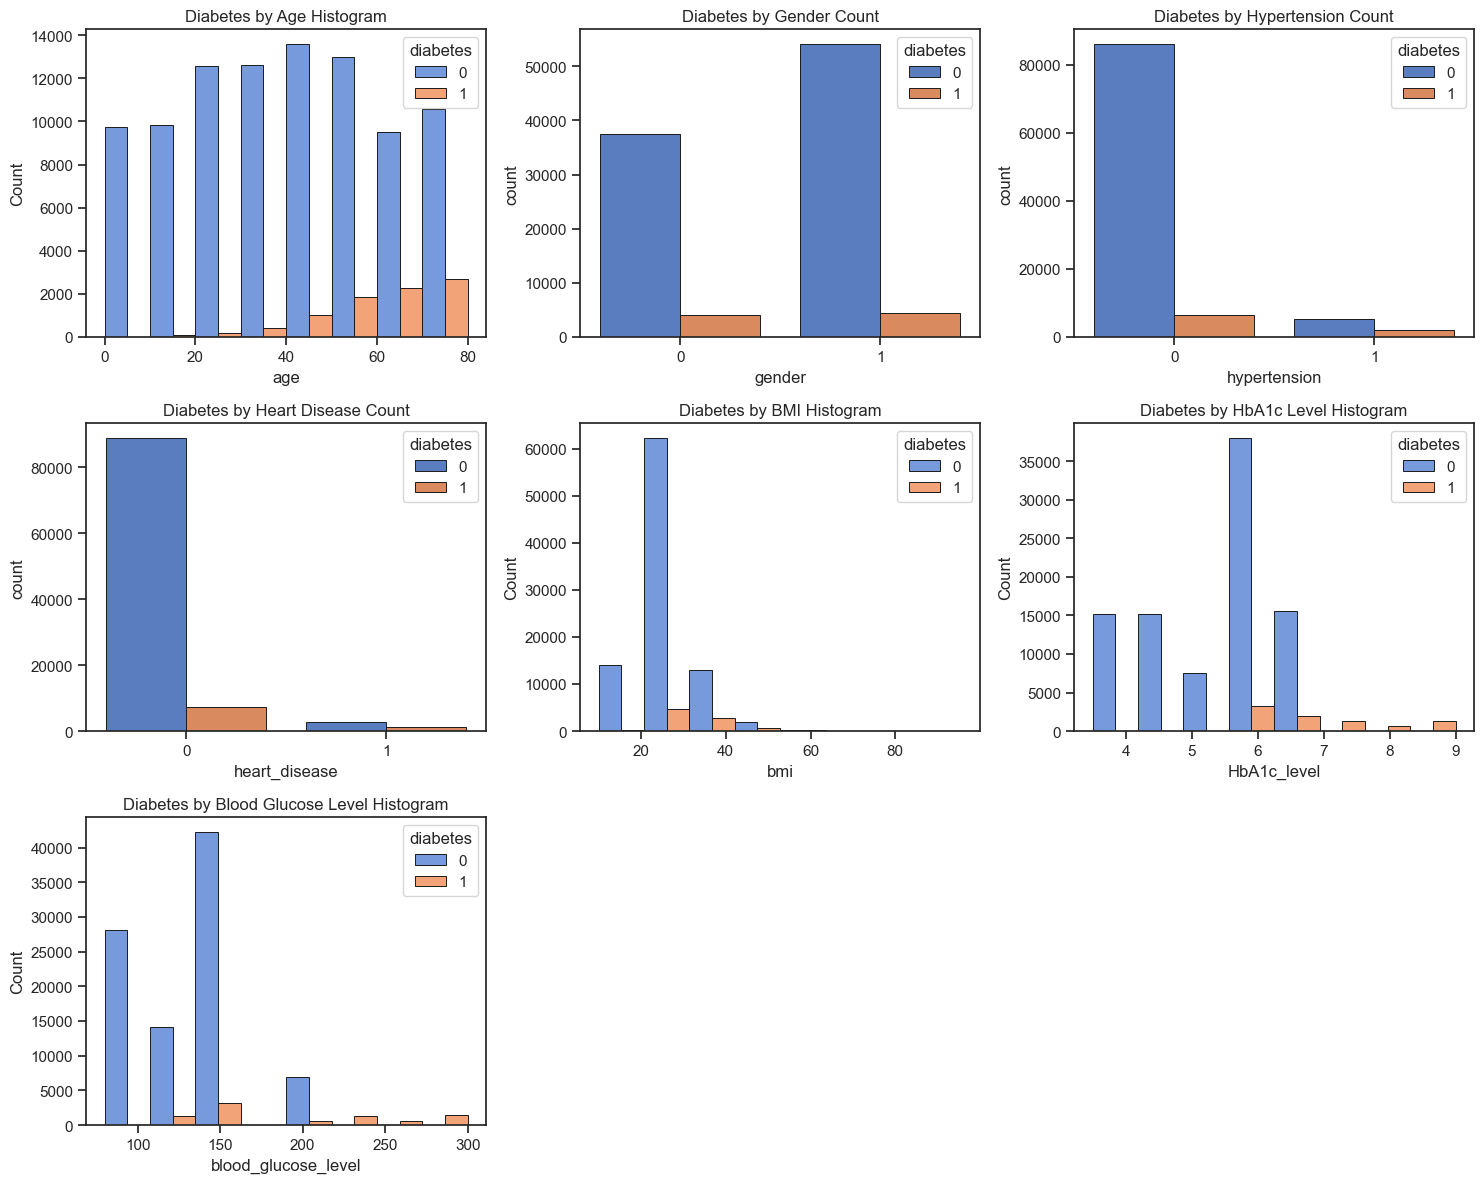

In [5]:
#Diabetes comparison charts
fig = plt.figure(figsize = (15, 12))
sns.set_theme(style = 'ticks')

#Age
plt.subplot(3, 3, 1)
sns.histplot(x = df['age'], hue = df['diabetes'], bins = 8, 
             multiple = 'dodge', palette = 'muted', linewidth = 0.7, edgecolor = 'k')
plt.title('Diabetes by Age Histogram')

#Gender
plt.subplot(3, 3, 2)
sns.countplot( x = df['gender'], hue = df['diabetes'],
             palette = 'muted', linewidth = 0.7, edgecolor = 'k')
plt.title('Diabetes by Gender Count')

#Hypertension
plt.subplot(3, 3, 3)
sns.countplot( x = df['hypertension'], hue = df['diabetes'],
             palette = 'muted', linewidth = 0.7, edgecolor = 'k')
plt.title('Diabetes by Hypertension Count')

#Heart Disease
plt.subplot(3, 3, 4)
sns.countplot( x = df['heart_disease'], hue = df['diabetes'],
             palette = 'muted', linewidth = 0.7, edgecolor = 'k')
plt.title('Diabetes by Heart Disease Count')

#BMI
plt.subplot(3, 3, 5)
sns.histplot(x = df['bmi'], hue = df['diabetes'], bins = 8, 
             multiple = 'dodge', palette = 'muted', linewidth = 0.7, edgecolor = 'k')
plt.title('Diabetes by BMI Histogram')

#HbA1c Level
plt.subplot(3, 3, 6)
sns.histplot(x = df['HbA1c_level'], hue = df['diabetes'], bins = 8, 
             multiple = 'dodge', palette = 'muted', linewidth = 0.7, edgecolor = 'k')
plt.title('Diabetes by HbA1c Level Histogram')

#Blood Glucose Level
plt.subplot(3, 3, 7)
sns.histplot(x = df['blood_glucose_level'], hue = df['diabetes'], bins = 8, 
             multiple = 'dodge', palette = 'muted', linewidth = 0.7, edgecolor = 'k')
plt.title('Diabetes by Blood Glucose Level Histogram')

plt.tight_layout()
plt.show()

---
## Variable Heatmap
In order to see exactly how each variable impacts diabetes we will be looking at a heatmap of all variables. Here we find that the three highest impacting variables are blood glucose level, HbA1c level, and age. With a respective corralation of 42%, 40%, and 26%.

When we compare this data with the charts above we see that anyone that has a blood glucose level over 200 always reported that they had diabetes. The same can be seen for Anyone with a HbA1c level of 7 or greater. It is clear that these levels have a high correlation on if a patient has diabetes or not.

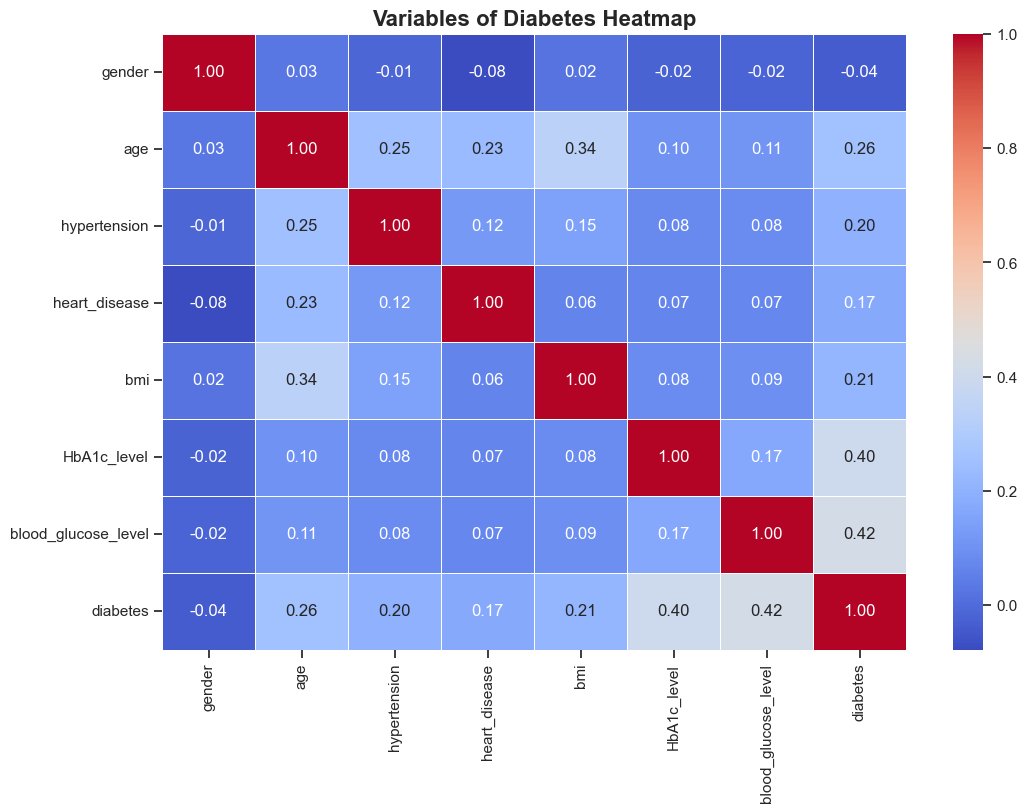

In [6]:
#Correlation matrix
plt.figure(figsize = (12,8))
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm', linewidth = 0.7, edgecolor = 'k', fmt = '.2f')
plt.title('Variables of Diabetes Heatmap', fontsize = '16', fontweight = 'bold')
plt.show()

In [7]:
#Set up training
X = df.drop('diabetes', axis = 1)
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [8]:
#Random forest training
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

---
## Machine Learning & Accuracy
We will now train our machine learning model to be able to predict if a patient has diabetes or not using our dataset of 99,982 patients. In order to train our model we will be using 80% of the data to build a random forest with branching logic options to find patterns in our patient data. After training the model we will then predict the diabetes results of the remaining 20% of patients.

From our predictions we have created a model that is able to accuratley estimate a patients diabetes status 97% of the time. From our 20% of patients 83 of them were false positives, 546 were false negatives, and 19,368 were correctly estimated.

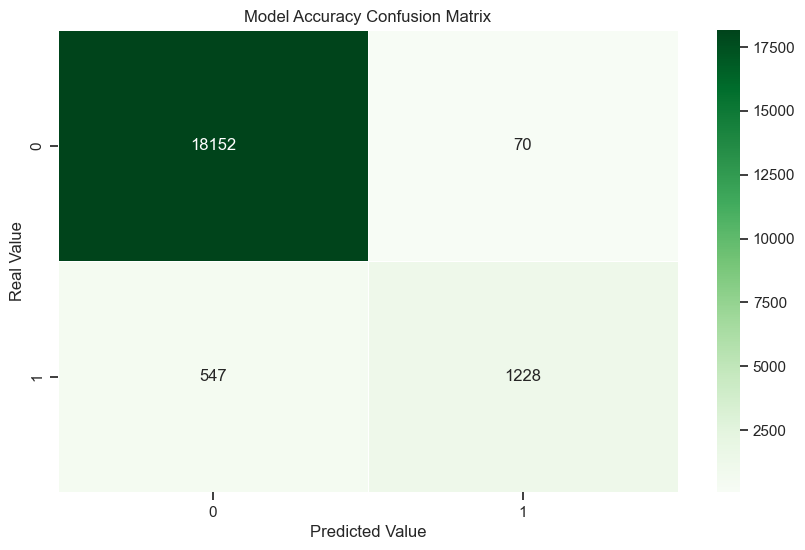

Model Accuracy:  0.97


In [9]:
#Plot confusion matrix
plt.figure(figsize = (10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, cmap = 'Greens', linewidth = 0.7, edgecolor = 'k', fmt='d')
plt.title('Model Accuracy Confusion Matrix')
plt.xlabel('Predicted Value')
plt.ylabel('Real Value')
plt.show()


#Accuracy evaluation
print('Model Accuracy: ', accuracy_score(y_test, y_pred).round(decimals = 2))

---
## Diabetes Prediction Tool
Below we have created a tool to help doctors and patients estimate if they are at risk of having diabetes. This tool is using our machine learning model to predict based on the information entered if the patient has diabetes.

In order to use this tool please enter your biological gender, age, BMI, HbA1c level, blood glucose level, hypertension, and heart disease status. Once you have entered all fields click 'Submit' and your results will appear below.

In [10]:
#Create widgets

#Gender
gender_widget = widgets.Dropdown(
    options = [('Male', 0), ('Female', 1)],
    description = 'Gender:',
)

#Age
age_widget = widgets.BoundedFloatText(
    min = 0,
    max = 100,
    step = 1,
    description = 'Age:'
)

#Hypertension
hypertension_widget = widgets.Checkbox(
    value = False,
    description = 'Hypertension',
    indent = True
)

#Heart Disease
heart_disease_widget = widgets.Checkbox(
    value = False,
    description = 'Heart Disease',
    indent = True
)

#BMI
bmi_widget = widgets.BoundedFloatText(
    min = 0.00,
    max = 100.00,
    step = 0.01,
    description = 'BMI:'
)

#HbA1c Level
HbA1c_widget = widgets.BoundedFloatText(
    min = 0.00,
    max = 10.00,
    step = 0.01,
    description = 'HbA1c Level:'
)

#Blood Glucose Level
blood_glucose_widget = widgets.BoundedFloatText(
    min = 0.00,
    max = 300.00,
    step = 0.01,
    description = 'Blood Glucose Level:',
    style = {'description_width': 'initial'}
)

#Submit
submit_button = widgets.Button(
    description = 'Submit'
)

#Output Prediction
output_prediction = widgets.Output()

#Prediction
def prediction(b):
    new_value = [gender_widget.value,
                age_widget.value,
                hypertension_widget.value,
                heart_disease_widget.value,
                bmi_widget.value,
                HbA1c_widget.value,
                blood_glucose_widget.value]
    prediction = rfc.predict(np.array(new_value).reshape(1,-1))[0]
    if prediction == 0:
        prediction = 'Based on the information provided it is likely that you do not have diabetes.'
    elif prediction == 1:
        prediction = 'Based on the information provided you are at a high risk of having diabetes.'
    with output_prediction:
        output_prediction.clear_output()
        print('Results:', prediction)

#Submit on click
submit_button.on_click(prediction)

In [11]:
#Display widgets
display(gender_widget,
        age_widget,
        bmi_widget,
        HbA1c_widget,
        blood_glucose_widget,
        hypertension_widget,
        heart_disease_widget,
        submit_button
       )
output_prediction

Dropdown(description='Gender:', options=(('Male', 0), ('Female', 1)), value=0)

BoundedFloatText(value=0.0, description='Age:', step=1.0)

BoundedFloatText(value=0.0, description='BMI:', step=0.01)

BoundedFloatText(value=0.0, description='HbA1c Level:', max=10.0, step=0.01)

BoundedFloatText(value=0.0, description='Blood Glucose Level:', max=300.0, step=0.01, style=DescriptionStyle(d…

Checkbox(value=False, description='Hypertension')

Checkbox(value=False, description='Heart Disease')

Button(description='Submit', style=ButtonStyle())

Output()

---
**Medical Advice Disclaimer:** The information on this page and the prediction tool do not provide medical advice. It is intended for educational purposes only. It is not a substitute for professional medical advice, diagnosis or treatment.